In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import wntr
import numpy as np
import csv
import pickle
import seaborn as sns

from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Get the L_TOWN network:

inp_file = '/Users/maryam/Desktop/Thesis/KIOS-Research-BattLeDIM.git/BattLeDIM/Dataset Generator/L-TOWN_Real.inp'

wn = wntr.network.WaterNetworkModel(inp_file)

In [3]:


# Bigger network chosen for  thesis picture
nodes = ['n186','n180','n178','n174', 'n173','n189','n195', 'n197', 'n194','n193']
pipes = ['p138','p612','p140','p625','p626','p613', 'p85','p94','p628','p143','p630','p629','p616','p141',
         'p605','p93','p134','p132','p601','p131','p203','p595','p136','p139']

pipe_diameter = {pipe: wn.get_link(pipe).diameter for pipe in pipes}

# One hour time step for tests.
#DEFAULT_TIMESTEP =  1 * 60 * 60

# For every 5 minutes
DEFAULT_TIMESTEP =  5 * 60


print("NODES:",nodes)
print("PIPES:",pipes)

NODES: ['n186', 'n180', 'n178', 'n174', 'n173', 'n189', 'n195', 'n197', 'n194', 'n193']
PIPES: ['p138', 'p612', 'p140', 'p625', 'p626', 'p613', 'p85', 'p94', 'p628', 'p143', 'p630', 'p629', 'p616', 'p141', 'p605', 'p93', 'p134', 'p132', 'p601', 'p131', 'p203', 'p595', 'p136', 'p139']


In [4]:
def createNetwork(duration, timestep):
    wn = wntr.network.WaterNetworkModel(inp_file) 
    wn.options.hydraulic.demand_model = 'PDD' 
    wn.options.time.duration = duration 
    wn.options.time.hydraulic_timestep = timestep 
    wn.options.time.report_timestep = timestep 
    return wn


def getLeakArea(pipe, percent): 
    d = pipe_diameter[pipe]
    d *= percent
    area = 3.14159 * (d / 2) ** 2 
    return area


def addLeak(wn, pipe, leak_area, leak_start, leak_duration): 
    node_leak = f'{pipe}_leaknode'
    wn = wntr.morph.split_pipe(wn, pipe, f'{pipe}_X', node_leak) 
    node_leak_ref = wn.get_node(node_leak) 
    node_leak_ref.add_leak(wn, discharge_coeff=0.75, area=leak_area,
        start_time=leak_start, end_time=(leak_start+leak_duration))
    return wn, node_leak


def leakResult(wn, pipe, leak_area, leak_start, leak_duration):
    wn, leak_node = addLeak(wn, pipe, leak_area, leak_start, leak_duration) 
    sim = wntr.sim.WNTRSimulator(wn)
    res = sim.run_sim()
    
    # All the pressure values for the sensors
    data = res.node['pressure'].loc[:,nodes]
    
    # Get leakage in l/m
    leak_data = res.node['leak_demand'].loc[:,leak_node].values 
    leak_data = [e * 3600 for e in leak_data]
    
    leak_or_no_leak = ['leak' if e > 0 else 'no_leak' for e in leak_data] 
    
    pipe_as_str = 'pipe_id: ' + str(pipe)
    pipe_or_no_leak = [pipe_as_str if e > 0 else 'no_leak' for e in leak_data] 
    
    data['leak_occurance'] = leak_or_no_leak
    data['pipe_leak_id'] = pipe_or_no_leak 
    
    # Maybe use for some regression method
    data['leak_amount'] = leak_data 
    return data

In [5]:
# Generate Training data:
def generateTrainData():
    # If we want to use TOWN_Real.inp we dont want
    # to load the network every time for each reset
    # so we use pickle
    wn = createNetwork(2 * 24 * 60 * 60, DEFAULT_TIMESTEP) 
    with open('temp_network.pickle', 'wb') as f:
        pickle.dump(wn, f)
    
    leak_start = 12 * 60 * 60 
    leak_duration = 24 * 60 * 60 
    all_results = []
    
    for pipe in pipes:
        print(pipe)
        
        # Use only one leak size for now.. 
        for leak_fraction in [0.15]:
            with open('temp_network.pickle', 'rb') as f:
                wn = pickle.load(f)
            leak_area = getLeakArea(pipe, leak_fraction)
            all_results.append( leakResult(wn, pipe, leak_area, leak_start,leak_duration) )
    
    # Make on big Dataframe
    big_frame = pd.concat(all_results, axis=0) 
    # Store the data in a csv-file
    with open('train_data.csv', 'w') as f:
            w = csv.writer(f)
            w.writerow(big_frame.columns)
            w.writerows(big_frame.values)


In [6]:
generateTrainData()

p138
p612
p140
p625
p626
p613
p85
p94
p628
p143
p630
p629
p616
p141
p605
p93
p134
p132
p601
p131
p203
p595
p136
p139


In [7]:
# Use all sensors
data = pd.read_csv('train_data.csv')

#data.drop_duplicates(inplace=True)
data.head()

,n186,n180,n178,n174,n173,n189,n195,n197,n194,n193,leak_occurance,pipe_leak_id,leak_amount
0,52.342023,51.384184,52.269742,52.749293,53.126603,55.507009,57.353417,57.593501,54.402627,54.458429,no_leak,no_leak,0.0
1,52.448203,51.490466,52.376464,52.856311,53.233936,55.614243,57.460322,57.700259,54.508926,54.564710,no_leak,no_leak,0.0
2,52.424206,51.466231,52.349722,52.828249,53.204589,55.585084,57.432469,57.673944,54.484706,54.540508,no_leak,no_leak,0.0
3,52.481496,51.523365,52.407448,52.886384,53.263455,55.644582,57.491856,57.732737,54.542313,54.598095,no_leak,no_leak,0.0
4,52.350331,51.392530,52.278512,52.758057,53.135214,55.515343,57.361658,57.601794,54.410968,54.466760,no_leak,no_leak,0.0


In [8]:
data.describe()

,n186,n180,n178,n174,n173,n189,n195,n197,n194,n193,leak_amount
count,13848.000000,13848.000000,13848.000000,13848.000000,13848.000000,13848.000000,13848.000000,13848.000000,13848.000000,13848.000000,13848.000000
mean,52.181813,51.233801,52.120846,52.600355,52.976654,55.344976,57.188138,57.428356,54.237032,54.292039,11.048866
std,0.504278,0.499559,0.493547,0.490316,0.486816,0.494612,0.501945,0.506615,0.506066,0.506159,13.332207
min,50.783296,49.878180,50.795456,51.284592,51.665604,53.954791,55.744026,55.937910,52.820097,52.879262,0.000000
25%,51.850518,50.900873,51.790909,52.273534,52.651882,55.024440,56.868019,57.104728,53.906307,53.960466,0.000000
50%,52.144158,51.196502,52.081701,52.561072,52.937361,55.308800,57.154191,57.394343,54.195109,54.250341,0.000000
75%,52.461699,51.512457,52.392102,52.872629,53.249622,55.620326,57.466116,57.712082,54.521345,54.577293,15.113012
max,53.137426,52.179290,53.054742,53.528283,53.898023,56.274885,58.128813,58.377246,55.196926,55.252926,41.117142


In [9]:
data.isna().sum()

n186              0
n180              0
n178              0
n174              0
n173              0
n189              0
n195              0
n197              0
n194              0
n193              0
leak_occurance    0
pipe_leak_id      0
leak_amount       0
dtype: int64

In [10]:
data_zero_value = (data == 0).sum(axis=0)
print('Ziro values: ', data_zero_value)

Ziro values:  n186                 0
n180                 0
n178                 0
n174                 0
n173                 0
n189                 0
n195                 0
n197                 0
n194                 0
n193                 0
leak_occurance       0
pipe_leak_id         0
leak_amount       6936
dtype: int64


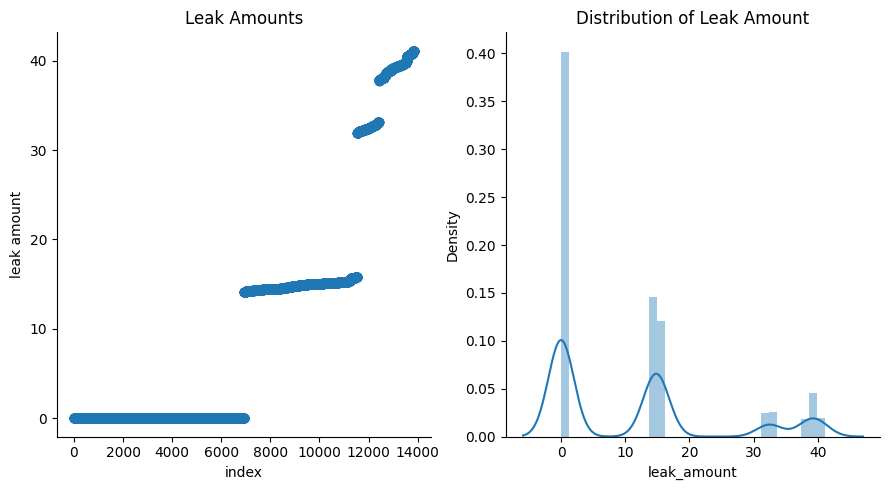

In [11]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(9, 5))

# Scatter plot
axes[0].scatter(range(data.shape[0]), np.sort(data['leak_amount'].values))
axes[0].set_xlabel('index')
axes[0].set_ylabel('leak amount')
axes[0].set_title("Leak Amounts")
sns.despine(ax=axes[0])

# Distribution plot
sns.distplot(data['leak_amount'], ax=axes[1])
axes[1].set_title("Distribution of Leak Amount")
sns.despine(ax=axes[1])

# Adjust spacing between subplots
plt.tight_layout()

# Show the merged plots
plt.show()

In [12]:
# Use all sensors
X = data[nodes]

# 'leak' .. 'no_leak'
y = data['leak_occurance']

print(X)


            n186       n180       n178       n174       n173       n189   
0      52.342023  51.384184  52.269742  52.749293  53.126603  55.507009  \
1      52.448203  51.490466  52.376464  52.856311  53.233936  55.614243   
2      52.424206  51.466231  52.349722  52.828249  53.204589  55.585084   
3      52.481496  51.523365  52.407448  52.886384  53.263455  55.644582   
4      52.350331  51.392530  52.278512  52.758057  53.135214  55.515343   
...          ...        ...        ...        ...        ...        ...   
13843  52.353870  51.395945  52.280166  52.758727  53.135236  55.515650   
13844  52.270579  51.312685  52.198251  52.677500  53.054200  55.433929   
13845  52.361785  51.403863  52.288885  52.767978  53.145144  55.525917   
13846  52.296680  51.338781  52.224791  52.704559  53.082488  55.463671   
13847  52.347434  51.389411  52.273371  52.752308  53.129415  55.510964   

            n195       n197       n194       n193  
0      57.353417  57.593501  54.402627  54.4584

In [13]:
print(y.value_counts()) # Shows if the dataset is balanced

leak_occurance
no_leak    6936
leak       6912
Name: count, dtype: int64


In [14]:
y= y.map({'leak': 1, 'no_leak': 0}).astype(int)

<Axes: xlabel='leak_occurance', ylabel='count'>

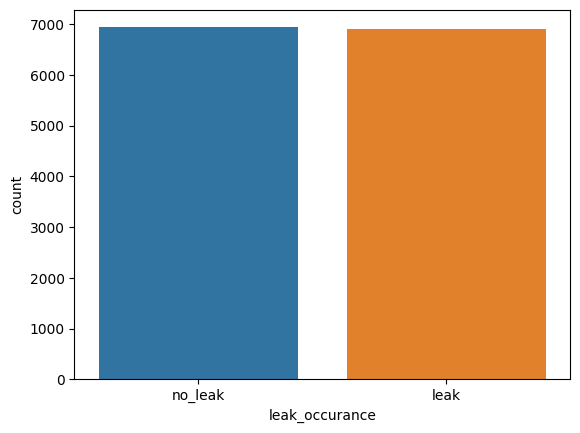

In [15]:

sns.countplot(x = data['leak_occurance'],label="Count")


In [16]:
data['leak_occurance'].value_counts()

leak_occurance
no_leak    6936
leak       6912
Name: count, dtype: int64

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
tuned_params =  {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 

cv_method = KFold(n_splits=4, shuffle=True)
model = SVC()
grid = GridSearchCV(estimator=model, param_grid=tuned_params, cv=cv_method, scoring='accuracy')
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
print(grid.best_score_)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9510882608414475
0.9529173887926055
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1695
           1       0.98      0.93      0.95      1767

    accuracy                           0.95      3462
   macro avg       0.95      0.95      0.95      3462
weighted avg       0.95      0.95      0.95      3462



In [18]:
forest_params = [{'max_depth': list(range(10, 15)), 'max_features': list(range(1,14))}]
rfc = RandomForestClassifier()
grid_rf = GridSearchCV(estimator=rfc, param_grid=forest_params,  cv=cv_method, scoring='accuracy')
grid_rf.fit(X_train, y_train)
y_pred = grid_rf.predict(X_test)
print(grid_rf.best_score_)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9611017038149388
0.9682264586943963
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1695
           1       1.00      0.94      0.97      1767

    accuracy                           0.97      3462
   macro avg       0.97      0.97      0.97      3462
weighted avg       0.97      0.97      0.97      3462



In [19]:
dtr = DecisionTreeClassifier()
parameters = {'splitter' : ['best', 'random'],
'criterion' : ['gini', 'entropy'],
'max_features': ['log2', 'sqrt','auto'],
'max_depth': [2, 3, 5, 10, 17],
'min_samples_split': [2, 3, 5, 7, 9],
'min_samples_leaf': [1,5,8,11],
'random_state' : [0,1,2,3,4,5]
}
grid_dt = GridSearchCV(estimator=dtr, param_grid=parameters,  cv=cv_method, scoring='accuracy')
grid_dt.fit(X_train, y_train)
y_pred = grid_dt.predict(X_test)
print(grid_dt.best_score_)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9663974610979956
0.9702484113229347
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1695
           1       1.00      0.94      0.97      1767

    accuracy                           0.97      3462
   macro avg       0.97      0.97      0.97      3462
weighted avg       0.97      0.97      0.97      3462



In [20]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
xgboost = XGBClassifier()
grid_xg = GridSearchCV(estimator=xgboost, param_grid=params,  cv=cv_method, scoring='accuracy')
grid_xg.fit(X_train, y_train)
y_pred = grid_xg.predict(X_test)
print(grid_xg.best_score_)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9721743575762717
0.9792027729636048
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1695
           1       1.00      0.96      0.98      1767

    accuracy                           0.98      3462
   macro avg       0.98      0.98      0.98      3462
weighted avg       0.98      0.98      0.98      3462



In [21]:
# DecisionTree
def test_tree(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
    dt = DecisionTreeClassifier() 
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    score = accuracy_score(y_test, y_pred) # accuracy of the model
    precision = precision_score(y_test, y_pred) # precision of the model
    recall = recall_score(y_test, y_pred) # recall of the model
    f1Score = f1_score(y_test, y_pred) # f1_score of the model
    return score, precision,recall, f1Score

In [22]:
# SVC
def test_svc(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=3)
    model = SVC()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred) # accuracy of the model
    precision = precision_score(y_test, y_pred) # precision of the model
    recall = recall_score(y_test, y_pred) # recall of the model
    f1Score = f1_score(y_test, y_pred) # f1_score of the model
    return score, precision, recall, f1Score


In [23]:
# XGBoost
def test_gb(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=3)
    clf1 = XGBClassifier()
    clf1.fit(X_train, y_train)
    y_pred = clf1.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred) # precision of the model
    recall = recall_score(y_test, y_pred) # recall of the model
    f1Score = f1_score(y_test, y_pred) # f1_score of the model
    return score, precision, recall, f1Score

In [24]:
# Random forest
def test_rf(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=3)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred) 
    precision = precision_score(y_test, y_pred) # precision of the model
    recall = recall_score(y_test, y_pred) # recall of the model
    f1Score = f1_score(y_test, y_pred) # f1_score of the model
    return score, precision, recall, f1Score

In [25]:

score_DT, precision_DT, recall_DT, f1Score_DT = test_tree(X,y)
print("Leak detection DTC accuracy\t: {:.1f}%".format(score_DT*100))
print("Leak detection DTC precision\t: {:.1f}%".format(precision_DT*100))
print("Leak detection DTC recall\t: {:.1f}%".format(recall_DT*100))
print("Leak detection DTC f1_score\t: {:.1f}%".format(f1Score_DT*100))
print('-------------------------------------------------------------')
score_SVC , precision_SVC, recall_SVC, f1Score_SVC= test_svc(X,y)
print("Leak detection SVC accuracy\t: {:.1f}%".format(score_SVC*100))
print("Leak detection SVC precision\t: {:.1f}%".format(precision_SVC*100))
print("Leak detection SVC recall\t: {:.1f}%".format(recall_SVC*100))
print("Leak detection SVC f1_score\t: {:.1f}%".format(f1Score_SVC*100))
print('-------------------------------------------------------------')
score_XG, precision_XG, recall_XG, f1Score_XG = test_gb(X,y)
print("Leak detection XGBoost accuracy\t: {:.1f}%".format(score_XG*100))
print("Leak detection XGBoost precision\t: {:.1f}%".format(precision_XG*100))
print("Leak detection XGBoost recall\t: {:.1f}%".format(recall_XG*100))
print("Leak detection XGBoost f1_score\t: {:.1f}%".format(f1Score_XG*100))
print('-------------------------------------------------------------')
score_RF, precision_RF, recall_RF, f1Score_RF = test_rf(X,y)
print("Leak detection RandomForest Accuracy\t: {:.1f}%".format(score_RF*100))
print("Leak detection RandomForest precision\t: {:.1f}%".format(precision_RF*100))
print("Leak detection RandomForest recall\t: {:.1f}%".format(recall_RF*100))
print("Leak detection RandomForest f1_score\t: {:.1f}%".format(f1Score_RF*100))

Leak detection DTC accuracy	: 98.9%
Leak detection DTC precision	: 100.0%
Leak detection DTC recall	: 97.9%
Leak detection DTC f1_score	: 98.9%
-------------------------------------------------------------
Leak detection SVC accuracy	: 68.9%
Leak detection SVC precision	: 86.9%
Leak detection SVC recall	: 45.9%
Leak detection SVC f1_score	: 60.1%
-------------------------------------------------------------
Leak detection XGBoost accuracy	: 97.9%
Leak detection XGBoost precision	: 100.0%
Leak detection XGBoost recall	: 95.8%
Leak detection XGBoost f1_score	: 97.9%
-------------------------------------------------------------
Leak detection RandomForest Accuracy	: 99.2%
Leak detection RandomForest precision	: 100.0%
Leak detection RandomForest recall	: 98.4%
Leak detection RandomForest f1_score	: 99.2%
